# Fault detection for INS of a ship described by Nomoto second order model

INS (Inertial navigation system) includes a gyriscope and accelerometer

## Data import and analysis

In [120]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [121]:
files = glob.glob('datasets/*.csv')

measurement_step = 100

data = []
for file in files:
  if(file != 'data_model.csv'):
      temp = pd.read_csv(file, usecols = ['u1', 'y1', 'y2', 'y_nominal1', 'y_nominal2', 'fault_u1',
       'fault_y1', 'fault_y2', 'comp_fault'])
      indexes = range(0, temp.shape[0], measurement_step)
      temp = temp.iloc[indexes][:]
      data.append(temp)      
len(data)

280

In [122]:
data[0].shape

(50, 9)

In [123]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 4900
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   u1          50 non-null     float64
 1   y1          50 non-null     float64
 2   y2          50 non-null     float64
 3   y_nominal1  50 non-null     float64
 4   y_nominal2  50 non-null     float64
 5   fault_u1    50 non-null     float64
 6   fault_y1    50 non-null     float64
 7   fault_y2    50 non-null     float64
 8   comp_fault  50 non-null     float64
dtypes: float64(9)
memory usage: 3.9 KB


In [124]:
data[10].tail()

,u1,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_y1,fault_y2,comp_fault
4500,-0.221198,-0.210813,0.165109,-0.251443,0.107338,0.0,0.0,0.0,0.0
4600,0.133344,-0.187746,0.585067,-0.199047,0.314831,0.0,0.0,0.0,0.0
4700,-0.014817,0.322831,-0.174711,0.346907,-0.258333,0.0,0.0,0.0,0.0
4800,-0.107118,0.045924,-0.181092,0.032668,-0.190933,0.0,0.0,0.0,0.0
4900,0.204413,-0.383175,0.228794,-0.362575,0.349905,0.0,0.0,0.0,0.0


Check fault cases

In [125]:
u1 = []
y1 = []
y2 = []
comp = []
for s in range(len(data)):
  df = data[s].loc[data[s]['fault_u1'] != 0]
  if (df.empty != True):
    u1.append(s)
  df = data[s].loc[data[s]['fault_y1'] != 0]
  if (df.empty != True):
    y1.append(s)
  df = data[s].loc[data[s]['fault_y2'] != 0]
  if (df.empty != True):
    y2.append(s)
  df = data[s].loc[(data[s]['fault_y2'] != 0) & (data[s]['fault_y1'] != 0)]
  if (df.empty != True):
    comp.append(s)

print('y1 faults in samples ', y1)
print('y2 faults in samples ', y2)

y1 faults in samples  [25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259]
y2 faults in samples  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 19

## Feature engineering

Add features:
- previous values for each measurement (parameter max_lag)
- rolling mean value (parameters rolling_mean_first_size and count_rolling)
- first derivative
- second derivative

In [126]:
def make_features(df, max_lag, rolling_mean_first_size, count_rolling):
    df_res = df.copy()
    # Add n lags
    for lag in range(1, max_lag + 1):
        df_res['y1_lag_{}'.format(lag)] = df_res['y1'].shift(lag)
        df_res['y2_lag_{}'.format(lag)] = df_res['y2'].shift(lag)
        df_res['y_nominal1_lag_{}'.format(lag)] = df_res['y_nominal1'].shift(lag)
        df_res['y_nominal2_lag_{}'.format(lag)] = df_res['y_nominal2'].shift(lag)
# Add rolling mean
    df_cols = ['y1',	'y2',	'y_nominal1',	'y_nominal2']
    for counts in range(1, (count_rolling + 1)):
      for rol in range(len(df_cols)):
        s = df_cols[rol]+'_rolling_mean_{}'.format(rolling_mean_first_size*counts)
        df_res[s] = df_res[df_cols[rol]].shift().rolling(rolling_mean_first_size*counts).mean()
        # Add first derivative
    if (max_lag > 0):
      df_res['Vy1'] = df_res['y1'] - df_res['y1_lag_1']
      df_res['Vy2'] = df_res['y2'] - df_res['y2_lag_1']
      df_res['Vy_nominal1'] = df_res['y_nominal1'] - df_res['y_nominal1_lag_1']
      df_res['Vy_nominal2'] = df_res['y_nominal2'] - df_res['y_nominal2_lag_1']
    if (max_lag > 1): # Add second derivative
      df_res['Ay1'] = df_res['Vy1'] - (df_res['y1_lag_1'] - df_res['y1_lag_2'])
      df_res['Ay2'] = df_res['Vy2'] - (df_res['y2_lag_1'] - df_res['y2_lag_2'])
      df_res['Ay_nominal1'] = df_res['Vy_nominal1'] - (df_res['y_nominal1_lag_1'] - df_res['y_nominal1_lag_2'])
      df_res['Ay_nominal2'] = df_res['Vy_nominal2'] - (df_res['y_nominal2_lag_1'] - df_res['y_nominal2_lag_2'])
    if (max_lag > 2): # Add third derivative
      df_res['jy1'] = df_res['Ay1'] - (df_res['y1_lag_1'] - 2*df_res['y1_lag_2'] + df_res['y1_lag_3'])
      df_res['jy2'] = df_res['Ay2'] - (df_res['y2_lag_1'] - 2*df_res['y2_lag_2'] + df_res['y2_lag_3'])
      df_res['jy_nominal1'] = df_res['Ay_nominal1'] - (df_res['y_nominal1_lag_1'] - 2*df_res['y_nominal1_lag_2'] + df_res['y_nominal1_lag_3'])
      df_res['jy_nominal2'] = df_res['Ay_nominal2'] - (df_res['y_nominal2_lag_1'] - 2*df_res['y_nominal2_lag_2'] + df_res['y_nominal2_lag_3'])

    df_res = df_res.dropna().reset_index(drop=True)
    return df_res

In [127]:
augmented_data = []
for df1 in data:
  df1 = df1.drop(['fault_u1', 'comp_fault'], axis=1)
  augmented_data.append(make_features(df1, 2, 5, 2))

In [128]:
len(augmented_data)

280

In [129]:
for df1 in augmented_data:
    df1['fault_y1'] = df1['fault_y1'].astype(np.int8)
    df1['fault_y2'] = df1['fault_y2'].astype(np.int8)

augmented_data[3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   u1                          40 non-null     float64
 1   y1                          40 non-null     float64
 2   y2                          40 non-null     float64
 3   y_nominal1                  40 non-null     float64
 4   y_nominal2                  40 non-null     float64
 5   fault_y1                    40 non-null     int8   
 6   fault_y2                    40 non-null     int8   
 7   y1_lag_1                    40 non-null     float64
 8   y2_lag_1                    40 non-null     float64
 9   y_nominal1_lag_1            40 non-null     float64
 10  y_nominal2_lag_1            40 non-null     float64
 11  y1_lag_2                    40 non-null     float64
 12  y2_lag_2                    40 non-null     float64
 13  y_nominal1_lag_2            40 non-nu

In [130]:
augmented_data[5].head()

,u1,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2,y1_lag_1,y2_lag_1,y_nominal1_lag_1,...,y_nominal1_rolling_mean_10,y_nominal2_rolling_mean_10,Vy1,Vy2,Vy_nominal1,Vy_nominal2,Ay1,Ay2,Ay_nominal1,Ay_nominal2
0,-0.073428,0.105847,0.012385,0.146901,0.158164,0,0,-0.001258,0.083172,0.011643,...,0.134420,-0.024413,0.107104,-0.070787,0.135258,0.125704,0.023451,-0.152879,-0.008436,-0.023655
1,-0.012372,0.098878,0.089909,0.175122,0.168609,0,0,0.105847,0.012385,0.146901,...,0.066189,0.009427,-0.006969,0.077524,0.028221,0.010446,-0.114073,0.148311,-0.107037,-0.115258
2,0.078177,0.152718,0.099235,0.075730,0.056184,0,0,0.098878,0.089909,0.175122,...,0.052430,0.036398,0.053840,0.009326,-0.099392,-0.112425,0.060808,-0.068198,-0.127613,-0.122871
3,-0.017638,-0.048143,-0.046339,-0.078847,-0.097184,0,0,0.152718,0.099235,0.075730,...,0.043781,0.036844,-0.200861,-0.145573,-0.154577,-0.153368,-0.254701,-0.154899,-0.055186,-0.040943
4,-0.071406,-0.240253,-0.185839,-0.175966,-0.179731,0,0,-0.048143,-0.046339,-0.078847,...,0.016382,0.010441,-0.192109,-0.139500,-0.097119,-0.082547,0.008752,0.006074,0.057459,0.070821


In [131]:
all_data = pd.DataFrame()
for df in augmented_data:
  all_data = pd.concat([all_data, df], ignore_index = True)
all_data.drop(['fault_u1', 'comp_fault'], axis=1, inplace=True)

KeyError: "['fault_u1', 'comp_fault'] not found in axis"

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   u1                          11200 non-null  float64
 1   y1                          11200 non-null  float64
 2   y2                          11200 non-null  float64
 3   y_nominal1                  11200 non-null  float64
 4   y_nominal2                  11200 non-null  float64
 5   fault_y1                    11200 non-null  int8   
 6   fault_y2                    11200 non-null  int8   
 7   y1_lag_1                    11200 non-null  float64
 8   y2_lag_1                    11200 non-null  float64
 9   y_nominal1_lag_1            11200 non-null  float64
 10  y_nominal2_lag_1            11200 non-null  float64
 11  y1_lag_2                    11200 non-null  float64
 12  y2_lag_2                    11200 non-null  float64
 13  y_nominal1_lag_2            112

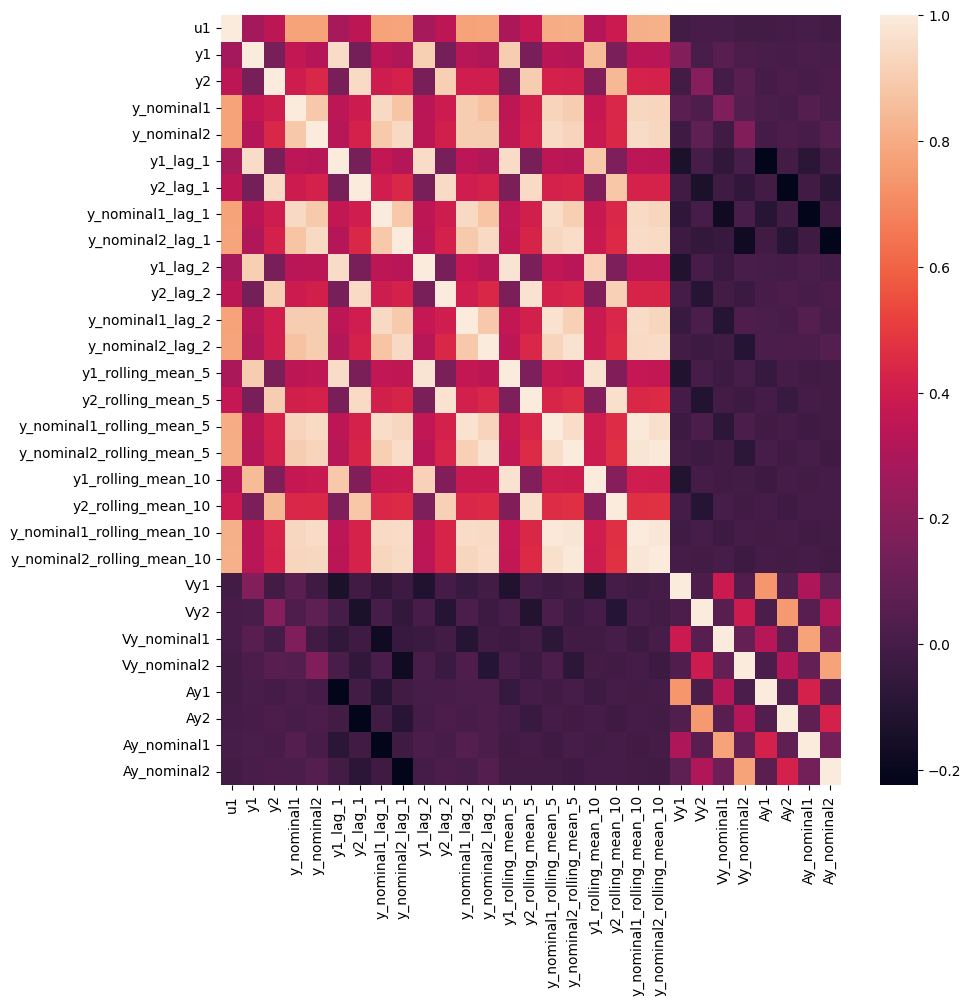

In [ ]:
def _heatmap(df):
  df_features = df.drop(['fault_y1', 'fault_y2'], axis = 1)
  cor = df_features.corr()
  plt.figure(figsize = (10, 10))
  sns.heatmap(cor)
  plt.show
  del df_features
  
_heatmap(all_data)

In [ ]:
all_data.describe()

,u1,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2,y1_lag_1,y2_lag_1,y_nominal1_lag_1,...,y_nominal1_rolling_mean_10,y_nominal2_rolling_mean_10,Vy1,Vy2,Vy_nominal1,Vy_nominal2,Ay1,Ay2,Ay_nominal1,Ay_nominal2
count,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,...,11200.000000,11200.000000,11200.000000,11200.000000,1.120000e+04,1.120000e+04,11200.000000,11200.000000,11200.000000,1.120000e+04
mean,-0.028475,0.022856,-0.130287,-0.084243,-0.084090,0.398036,0.361071,0.024257,-0.129914,-0.084018,...,-0.084251,-0.083814,-0.001401,-0.000373,-2.247097e-04,-2.617901e-05,-0.001784,0.001071,-0.000514,1.062971e-04
std,0.243335,1.597009,1.670187,0.626377,0.626163,0.873842,0.841901,1.584831,1.655662,0.626477,...,0.592302,0.595454,0.504388,0.541272,2.169066e-01,2.169281e-01,0.726994,0.805013,0.336246,3.359682e-01
min,-0.497757,-7.880744,-9.678349,-1.444806,-1.444806,0.000000,0.000000,-7.880744,-9.678349,-1.444806,...,-1.444806,-1.444806,-9.848734,-9.985708,-1.018831e+00,-1.017725e+00,-9.850683,-9.985708,-1.655907,-1.656808e+00
25%,-0.209246,-0.452468,-0.505974,-0.407136,-0.407136,0.000000,0.000000,-0.451242,-0.504040,-0.407136,...,-0.326837,-0.326837,-0.064179,-0.122567,-1.538826e-04,-5.829303e-04,-0.111263,-0.201267,-0.000886,-4.395373e-13
50%,-0.019545,-0.025425,-0.047165,-0.021658,-0.022765,0.000000,0.000000,-0.024380,-0.047560,-0.021658,...,-0.002112,-0.001914,0.000000,0.000000,1.665779e-12,4.440892e-16,0.000000,0.000000,0.000000,0.000000e+00
75%,0.151155,0.282306,0.273972,0.185532,0.180075,0.000000,0.000000,0.282306,0.271045,0.186285,...,0.022637,0.020480,0.065318,0.119681,2.141341e-05,4.959921e-13,0.110493,0.201583,0.000030,1.527948e-04
max,0.496916,8.728162,9.327207,1.429651,1.429651,3.000000,3.000000,8.728162,9.327207,1.429651,...,1.429651,1.429651,9.850683,9.858131,1.021889e+00,1.022025e+00,9.891249,10.297648,1.656833,1.655833e+00


## Dataset preparation

In [ ]:
augmented_data[0].shape

(40, 31)

In [132]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_data.drop(['fault_y1', 'fault_y2'], axis=1))
scaler.feature_names_in_

array(['u1', 'y1', 'y2', 'y_nominal1', 'y_nominal2', 'y1_lag_1',
       'y2_lag_1', 'y_nominal1_lag_1', 'y_nominal2_lag_1', 'y1_lag_2',
       'y2_lag_2', 'y_nominal1_lag_2', 'y_nominal2_lag_2',
       'y1_rolling_mean_5', 'y2_rolling_mean_5',
       'y_nominal1_rolling_mean_5', 'y_nominal2_rolling_mean_5',
       'y1_rolling_mean_10', 'y2_rolling_mean_10',
       'y_nominal1_rolling_mean_10', 'y_nominal2_rolling_mean_10', 'Vy1',
       'Vy2', 'Vy_nominal1', 'Vy_nominal2', 'Ay1', 'Ay2', 'Ay_nominal1',
       'Ay_nominal2'], dtype=object)

In [133]:
import numpy as np

X, y = [], []

lag = 10
k, total = 0, len(augmented_data)
for single_data in augmented_data:
    for i in range(lag, single_data.shape[0]):
        df = single_data.loc[(i-lag):i, :]
        sample_X = df.drop(['fault_y1', 'fault_y2'], axis=1)
        sample_X = scaler.transform(sample_X)
        sample_y = np.array(df[['fault_y1', 'fault_y2']])
        sample_y = np.array([bool(np.sum(sample_y[:, 0])), bool(np.sum(sample_y[:, 1]))], dtype=np.int8)
        X.append(np.array(sample_X))
        y.append(np.array(sample_y))
    k += 1
    print(k, 'of ', total) 
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

1 of  280
2 of  280
3 of  280
4 of  280
5 of  280
6 of  280
7 of  280
8 of  280
9 of  280
10 of  280
11 of  280
12 of  280
13 of  280
14 of  280
15 of  280
16 of  280
17 of  280
18 of  280
19 of  280
20 of  280
21 of  280
22 of  280
23 of  280
24 of  280
25 of  280
26 of  280
27 of  280
28 of  280
29 of  280
30 of  280
31 of  280
32 of  280
33 of  280
34 of  280
35 of  280
36 of  280
37 of  280
38 of  280
39 of  280
40 of  280
41 of  280
42 of  280
43 of  280
44 of  280
45 of  280
46 of  280
47 of  280
48 of  280
49 of  280
50 of  280
51 of  280
52 of  280
53 of  280
54 of  280
55 of  280
56 of  280
57 of  280
58 of  280
59 of  280
60 of  280
61 of  280
62 of  280
63 of  280
64 of  280
65 of  280
66 of  280
67 of  280
68 of  280
69 of  280
70 of  280
71 of  280
72 of  280
73 of  280
74 of  280
75 of  280
76 of  280
77 of  280
78 of  280
79 of  280
80 of  280
81 of  280
82 of  280
83 of  280
84 of  280
85 of  280
86 of  280
87 of  280
88 of  280
89 of  280
90 of  280
91 of  280
92 of  2

In [134]:
X.tofile('X_data.csv', sep=',')
y.tofile('y_data.csv', sep=',')

In [136]:
X = np.fromfile('X_data.csv', dtype=float, sep=',')
y = np.fromfile('y_data.csv', dtype=np.int8, sep=',')
X = X.reshape((8400, 11, 29))
y = y.reshape((8400, 2))
X.shape, y.shape

((8400, 11, 29), (8400, 2))

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 